In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [2]:
from Model.FastSCNN import *
from Dataset.dataset import *

In [3]:
with open("params.yml") as file:
    params = load(file, Loader=Loader)
    
dataset_path = params["dataset_path"]   # Path at which the dataset is located
crop_height  = params["crop_height"]    # Height of cropped/resized input image
crop_width   = params["crop_width"]     # Width of cropped/resized input image
num_classes  = params["num_classes"]    # Number of classes

In [4]:
test_dataset = Dataset(dataset_path, crop_height, crop_width, mode="test")
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size  = 1,
    num_workers = 4,
    shuffle     = True
)
dataloader = iter(test_dataloader)

In [5]:
image, label = next(dataloader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


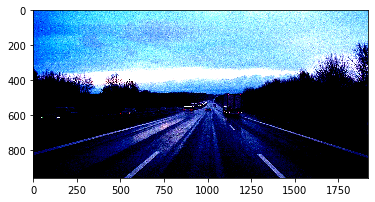

In [6]:
# normalized image
plt.imshow(np.moveaxis(image[0].detach().numpy(), 0, -1))
plt.show()

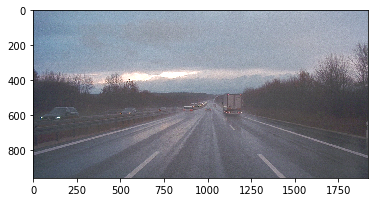

In [7]:
# denormalized image
plt.imshow(np.moveaxis(np.array(test_dataset.denormalize(image[0])), 0, -1))
plt.show()

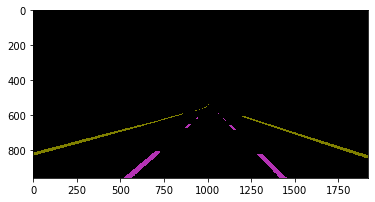

In [8]:
plt.imshow(colourize(label[0].detach().numpy(), test_dataset.class_dict))
plt.show()

In [9]:
model = FastSCNN(image_height   = crop_height,
                 image_width    = crop_width,
                 image_channels = 3,
                 num_classes    = num_classes)

In [10]:
model.load_state_dict(torch.load("./checkpoints/latest_model.pt"))

<All keys matched successfully>

In [11]:
with torch.no_grad():
    model.eval()
    
    output = model(image)

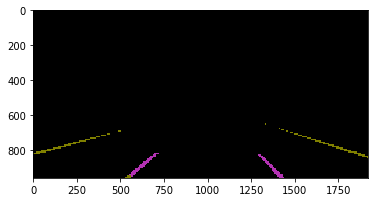

In [12]:
plt.imshow(colourize(reverse_one_hot(output[0]), test_dataset.class_dict))
plt.show()

## Testing Accuracy

In [13]:
def compute_hist(a, b, n):
	k = (a >= 0) & (a < n)
	return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

iou_per_class = lambda hist: (np.diag(hist) + 1e-5) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + 1e-5)

def run_test():

    with torch.no_grad(), tqdm(total=1000, position=0, leave=False) as val_progress:
        model.eval()
    
        val_progress.set_description('testing')
        
        precisions = []
        hist = np.zeros((num_classes, num_classes))

        for i, (data, label) in enumerate(test_dataloader):
                            
            output = model(data).squeeze()
            output = reverse_one_hot(output)
            output = np.array(output)

            label = label.squeeze()
            label = np.array(label)

            precisions.append(np.sum(output == label) / np.prod(label.shape))
            hist += compute_hist(output.flatten(), label.flatten(), num_classes)
            
            val_progress.set_postfix(precision='%.6f' % np.mean(precisions))
            val_progress.update()
            
            if i >= 1000:
                break
        
        precision = np.mean(precisions)
        iou = iou_per_class(hist)[:-1]
        miou = np.mean(iou)
    
    return precision, miou, iou

In [14]:
precision, miou, iou = run_test()

In [15]:
precision

0.9843871834545662

In [16]:
miou

0.49510420527508464

In [17]:
iou

array([0.98471499, 0.44548628, 0.24608556, 0.30412999])

## Timing Results

In [18]:
img = torch.randn(1, 3, 960, 1920)

In [19]:
%%timeit

with torch.no_grad():
    model.eval()
    
    label = model(img)

383 ms ± 13.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
